This notebook tests the generation of the CLEVR with masks dataset.

# Image generation

In [3]:
%cd image_generation
!./blender/blender --background \
    --python render_images.py -- \
    --num_images 10 --use_gpu 1 --min_objects 2 --max_objects 6
%cd ..

/dfs/user/liuk/reasoning/clevr_dataset_gen/image_generation
AL lib: (EE) ALCplaybackOSS_open: Could not open /dev/dsp: No such file or directory
found bundled python: /dfs/user/liuk/reasoning/clevr_dataset_gen/image_generation/blender/2.78/python
read blend: data/base_scene.blend
convertViewVec: called in an invalid context
convertViewVec: called in an invalid context
convertViewVec: called in an invalid context
0.2498259730027308 0.4 right
BROKEN MARGIN!
0.11816491454907707 0.4 left
BROKEN MARGIN!
0.31307834991033046 0.4 front
BROKEN MARGIN!
0.06981415725537676 0.4 front
BROKEN MARGIN!
0.1765139023033555 0.4 behind
BROKEN MARGIN!
convertViewVec: called in an invalid context
Fra:1 Mem:16.59M (0.00M, Peak 16.59M) | Time:00:00.00 | Preparing Scene data
Fra:1 Mem:25.30M (0.00M, Peak 26.28M) | Time:00:00.02 | Preparing Scene data
Fra:1 Mem:25.30M (0.00M, Peak 26.28M) | Time:00:00.02 | Creating Shadowbuffers
Fra:1 Mem:25.30M (0.00M, Peak 26.28M) | Time:00:00.02 | Raytree.. preparing
Fra:1 M

# Question template generation

In [4]:
!pip install pyjson5

     |████████████████████████████████| 232 kB 6.6 MB/s eta 0:00:01


In [5]:
%cd relation_generator
!python generate_relations.py
%cd ..

/dfs/user/liuk/reasoning/clevr_dataset_gen/relation_generator
Generating relations
Saving templates to ../question_generation/babyarc
Generating relations for same_shape and same_shape
Generating relations for same_shape and same_material
Generating relations for same_shape and same_size
Generating relations for same_shape and same_color
Generating relations for same_material and same_shape
Generating relations for same_material and same_material
Generating relations for same_material and same_size
Generating relations for same_material and same_color
Generating relations for same_size and same_shape
Generating relations for same_size and same_material
Generating relations for same_size and same_size
Generating relations for same_size and same_color
Generating relations for same_color and same_shape
Generating relations for same_color and same_material
Generating relations for same_color and same_size
Generating relations for same_color and same_color
/dfs/user/liuk/reasoning/clevr_dat

# Question generation

In [20]:
%cd question_generation/
!python generate_questions.py --input_scene_file /dfs/user/tailin/.results/CLEVR_relation/mpi/combined/CLEVR_scenes.json --output_questions_file /dfs/user/tailin/.results/CLEVR_relation/mpi/combined/questions.json --template_dir babyarc --max-num-objects 6
%cd ..

/dfs/user/liuk/reasoning/clevr_dataset_gen/question_generation
Read 32 templates from disk
starting image CLEVR_new_000000.png (1 / 2000)
resetting counts
starting image CLEVR_new_000001.png (2 / 2000)
starting image CLEVR_new_000002.png (3 / 2000)
starting image CLEVR_new_000003.png (4 / 2000)
starting image CLEVR_new_000004.png (5 / 2000)
starting image CLEVR_new_000005.png (6 / 2000)
starting image CLEVR_new_000006.png (7 / 2000)
starting image CLEVR_new_000007.png (8 / 2000)
starting image CLEVR_new_000008.png (9 / 2000)
starting image CLEVR_new_000009.png (10 / 2000)
starting image CLEVR_new_000010.png (11 / 2000)
starting image CLEVR_new_000011.png (12 / 2000)
starting image CLEVR_new_000012.png (13 / 2000)
starting image CLEVR_new_000013.png (14 / 2000)
starting image CLEVR_new_000014.png (15 / 2000)
starting image CLEVR_new_000015.png (16 / 2000)
starting image CLEVR_new_000016.png (17 / 2000)
starting image CLEVR_new_000017.png (18 / 2000)
starting image CLEVR_new_000018.png (

# Question analysis

In [2]:
from collections import defaultdict
import json
from typing import List

from relation_generator.generate_relations import RELATIONS

def get_unique_task_string(program: List[str]):
    """
    Parses the program for a given question and returns a unique string that identifies the 
    babyARC task that it embodies.

    This function is somewhat hacky in that it doesn't deal with the AST directly, but it
    works for the generated babyARC template programs.
    """
    inputs = []
    object_str = []
    for node in program:
        # Generate a new object str every time we see a new "scene" (which implies
        # a new object)
        if node["type"] == "scene":
            if len(object_str) != 0:
                inputs.append(",".join(object_str))
                object_str = []
            continue

        # If we're not at a scene, then we're in the middle of an object
        if node["type"].startswith("filter_"):
            # This node filters some property of the input. Let's consider it.
            object_str.append(node["type"][7:] + "=" + node["value_inputs"][0])
    inputs.append(",".join(object_str))
    relations = sorted([node["type"] for node in program if node["type"] in RELATIONS])
    
    return "+".join(relations) + "-" + ";".join(inputs)


# Load the question data
file = "question_generation/questions.json"
with open(file) as f:
    data = json.load(f)
question_list = data["questions"]

observed_question_types = dict()

# Count the number of times each question type occurs
for question in question_list:
    template_filename = question["template_filename"]
    question_family_index = question["question_family_index"]
    program = question["program"]
    image = question["image"]

    task_str = get_unique_task_string(program)

    if task_str not in observed_question_types:
        observed_question_types[task_str] = {"count": 0, "questions": [], "images": []}
    
    observed_question_types[task_str]["count"] += 1
    observed_question_types[task_str]["questions"].append(question)
    observed_question_types[task_str]["images"].append(image)
for task_str, data in observed_question_types.items():
    print("{} - {}".format(task_str, data["count"]))

same_shape-color=purple,material=metal - 2
same_shape+same_shape-material=rubber;size=large,color=green,shape=sphere - 1
same_material+same_shape-color=green;size=large,color=purple,shape=sphere - 1
same_shape-color=cyan,shape=cylinder - 2
same_shape+same_size-color=purple,material=rubber;color=green - 1
same_color+same_size-size=large,material=rubber;size=large,color=cyan,shape=cylinder - 1
same_color-size=large,material=rubber,shape=sphere - 8
same_color+same_shape-material=rubber;size=large,color=cyan,material=metal,shape=cylinder - 1
same_color+same_size-material=rubber;color=cyan,shape=sphere - 1
same_size-size=small,color=red,material=metal - 2
same_material+same_size-size=small,color=red;color=green,material=metal,shape=sphere - 1
same_material-size=large,color=cyan,shape=cylinder - 2
same_size-size=small,color=red - 4
same_material-color=brown,shape=cylinder - 1
same_material+same_size-color=green;color=cyan,material=metal,shape=sphere - 1
same_material-color=brown - 7
same_mat

In [34]:
import pandas as pd

df = pd.DataFrame.from_dict(observed_question_types, orient='index')

In [42]:
df.sort_values(by=["count"], ascending=False).images[0]

['CLEVR_new_000001',
 'CLEVR_new_000002',
 'CLEVR_new_000002',
 'CLEVR_new_000003']

In [3]:
observed_question_types["same_size-size=large,color=purple,material=metal"]

{'count': 5,
 'questions': [{'split': 'new',
   'image_filename': 'CLEVR_new_000010.png',
   'image_index': 10,
   'image': 'CLEVR_new_000010',
   'question': 'What is the object with the same_size as the large purple metallic thing?',
   'program': [{'type': 'scene',
     'inputs': [],
     '_output': [0, 1, 2],
     'value_inputs': []},
    {'type': 'filter_size',
     'inputs': [0],
     '_output': [0, 2],
     'value_inputs': ['large']},
    {'type': 'filter_color',
     'inputs': [1],
     '_output': [2],
     'value_inputs': ['purple']},
    {'type': 'filter_material',
     'inputs': [2],
     '_output': [2],
     'value_inputs': ['metal']},
    {'type': 'unique', 'inputs': [3], '_output': 2, 'value_inputs': []},
    {'type': 'same_size', 'inputs': [4], '_output': [0], 'value_inputs': []},
    {'type': 'unique', 'inputs': [5], '_output': 0, 'value_inputs': []}],
   'answer': 0,
   'template_filename': 'same_size-same_shape.json',
   'question_family_index': 0,
   'question_index'

# Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import ClevrRelationDataset

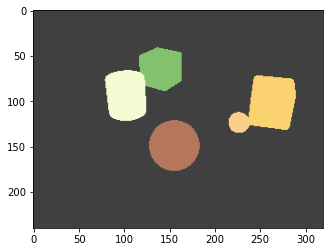

In [65]:
plt.imshow(Image.open("/dfs/user/tailin/.results/CLEVR_relation/mpi/combined/images/CLEVR_new_000005_mask.png"))

In [30]:
dataset = ClevrRelationDataset(image_dir="/dfs/user/tailin/.results/CLEVR_relation/mpi/combined/images", question_dir="/dfs/user/tailin/.results/CLEVR_relation/mpi/combined")

  0%|          | 11/17558 [00:00<14:34, 20.06it/s] 

0


  1%|          | 100/17558 [00:03<12:08, 23.95it/s]

0


  1%|          | 208/17558 [00:07<10:41, 27.03it/s]

0


  2%|▏         | 310/17558 [00:08<03:24, 84.20it/s]

0


  2%|▏         | 403/17558 [00:12<08:23, 34.05it/s]

0


  3%|▎         | 511/17558 [00:15<06:33, 43.28it/s]

1


  3%|▎         | 605/17558 [00:17<05:00, 56.43it/s]

1


  4%|▍         | 710/17558 [00:19<04:25, 63.56it/s]

1


  5%|▍         | 801/17558 [00:22<09:33, 29.21it/s]

2


  5%|▌         | 901/17558 [00:26<09:02, 30.70it/s]

4


  6%|▌         | 1007/17558 [00:27<03:01, 91.02it/s]

9


  6%|▋         | 1104/17558 [00:29<07:08, 38.42it/s]

14


  7%|▋         | 1217/17558 [00:33<04:45, 57.14it/s]

22


  7%|▋         | 1305/17558 [00:36<07:09, 37.80it/s]

26


  8%|▊         | 1419/17558 [00:38<03:40, 73.09it/s]

32


  9%|▊         | 1516/17558 [00:41<04:58, 53.77it/s]

39


  9%|▉         | 1611/17558 [00:44<06:28, 41.06it/s]

45


 10%|▉         | 1721/17558 [00:47<04:17, 61.58it/s]

51


 10%|█         | 1810/17558 [00:49<05:24, 48.51it/s]

55


 11%|█         | 1913/17558 [00:52<04:17, 60.78it/s]

59


 11%|█▏        | 2011/17558 [00:55<04:49, 53.66it/s]

65


 12%|█▏        | 2105/17558 [00:57<06:16, 41.04it/s]

69


 13%|█▎        | 2219/17558 [01:00<04:16, 59.82it/s]

77


 13%|█▎        | 2314/17558 [01:03<05:00, 50.77it/s]

83


 14%|█▎        | 2402/17558 [01:05<04:39, 54.18it/s]

88


 14%|█▍        | 2518/17558 [01:06<02:52, 87.26it/s]

93


 15%|█▍        | 2597/17558 [01:09<14:03, 17.73it/s] 

102


 15%|█▌        | 2708/17558 [01:12<04:39, 53.16it/s]

105


 16%|█▌        | 2803/17558 [01:15<09:32, 25.76it/s]

109


 17%|█▋        | 2920/17558 [01:17<02:53, 84.41it/s]

113


 17%|█▋        | 3002/17558 [01:20<08:22, 28.96it/s]

122


 18%|█▊        | 3109/17558 [01:22<04:18, 55.84it/s]

125


 18%|█▊        | 3207/17558 [01:26<06:22, 37.54it/s]

127


 19%|█▉        | 3305/17558 [01:28<05:42, 41.60it/s]

136


 19%|█▉        | 3399/17558 [01:31<08:34, 27.51it/s]

139


 20%|█▉        | 3507/17558 [01:34<04:24, 53.06it/s]

140


 21%|██        | 3609/17558 [01:36<03:43, 62.35it/s]

141


 21%|██        | 3719/17558 [01:39<05:44, 40.12it/s]

148


 22%|██▏       | 3816/17558 [01:43<05:51, 39.11it/s]

152


 22%|██▏       | 3909/17558 [01:45<04:21, 52.20it/s]

157


 23%|██▎       | 3998/17558 [01:47<03:29, 64.61it/s]

159


 23%|██▎       | 4097/17558 [01:49<06:13, 36.00it/s]

163


 24%|██▍       | 4194/17558 [01:52<04:19, 51.49it/s]

166


 24%|██▍       | 4298/17558 [01:55<06:40, 33.08it/s]

170


 25%|██▌       | 4415/17558 [01:57<02:57, 73.87it/s]

175


 26%|██▌       | 4510/17558 [01:59<03:40, 59.16it/s]

177


 26%|██▌       | 4602/17558 [02:02<08:30, 25.37it/s]

181


 27%|██▋       | 4705/17558 [02:04<04:14, 50.47it/s]

186


 27%|██▋       | 4797/17558 [02:06<08:18, 25.60it/s]

190


 28%|██▊       | 4909/17558 [02:09<03:56, 53.51it/s]

192


 28%|██▊       | 5000/17558 [02:11<04:52, 42.97it/s]

193


 29%|██▉       | 5103/17558 [02:14<02:47, 74.18it/s]

197


 30%|██▉       | 5204/17558 [02:17<04:44, 43.35it/s]

200


 30%|███       | 5308/17558 [02:20<06:27, 31.64it/s]

202


 31%|███       | 5400/17558 [02:22<04:25, 45.82it/s]

205


 31%|███▏      | 5500/17558 [02:24<02:29, 80.42it/s]

208


 32%|███▏      | 5608/17558 [02:27<05:18, 37.47it/s]

212


 32%|███▏      | 5693/17558 [02:30<07:52, 25.13it/s]

216


 33%|███▎      | 5815/17558 [02:34<05:02, 38.86it/s]

219


 34%|███▎      | 5904/17558 [02:36<03:32, 54.94it/s]

222


 34%|███▍      | 6003/17558 [02:38<09:37, 20.02it/s]

223


 35%|███▍      | 6098/17558 [02:42<11:18, 16.90it/s]

226


 35%|███▌      | 6206/17558 [02:44<03:36, 52.35it/s]

228


 36%|███▌      | 6307/17558 [02:47<04:40, 40.06it/s]

232


 37%|███▋      | 6416/17558 [02:50<03:46, 49.10it/s]

233


 37%|███▋      | 6512/17558 [02:53<03:35, 51.18it/s]

233


 38%|███▊      | 6613/17558 [02:55<02:15, 80.92it/s]

236


 38%|███▊      | 6702/17558 [02:57<05:41, 31.79it/s]

236


 39%|███▊      | 6802/17558 [02:59<03:50, 46.70it/s]

239


 39%|███▉      | 6917/17558 [03:02<02:38, 66.99it/s]

241


 40%|███▉      | 7003/17558 [03:03<02:27, 71.42it/s]

245


 41%|████      | 7120/17558 [03:06<03:04, 56.45it/s]

245


 41%|████      | 7208/17558 [03:08<05:19, 32.39it/s]

248


 42%|████▏     | 7294/17558 [03:11<05:06, 33.52it/s]

248


 42%|████▏     | 7416/17558 [03:13<02:10, 77.77it/s]

248


 43%|████▎     | 7509/17558 [03:15<02:34, 65.07it/s]

253


 43%|████▎     | 7601/17558 [03:19<06:39, 24.89it/s]

254


 44%|████▍     | 7710/17558 [03:22<03:33, 46.22it/s]

254


 44%|████▍     | 7799/17558 [03:24<02:49, 57.68it/s]

256


 45%|████▌     | 7904/17558 [03:27<02:46, 57.91it/s]

258


 46%|████▌     | 8004/17558 [03:30<04:54, 32.47it/s]

258


 46%|████▌     | 8109/17558 [03:33<03:07, 50.37it/s]

261


 47%|████▋     | 8218/17558 [03:36<03:09, 49.18it/s]

263


 47%|████▋     | 8310/17558 [03:37<02:05, 73.74it/s]

263


 48%|████▊     | 8411/17558 [03:42<06:19, 24.09it/s]

263


 48%|████▊     | 8511/17558 [03:44<02:50, 53.07it/s]

263


 49%|████▉     | 8607/17558 [03:46<05:32, 26.95it/s]

266


 51%|█████     | 8906/17558 [03:55<03:58, 36.33it/s]

269


 51%|█████▏    | 9004/17558 [03:57<04:25, 32.28it/s]

272


 52%|█████▏    | 9111/17558 [04:02<05:01, 28.02it/s]

273


 52%|█████▏    | 9213/17558 [04:03<01:28, 94.40it/s]

273


 53%|█████▎    | 9303/17558 [04:05<03:14, 42.52it/s] 

276


 54%|█████▎    | 9402/17558 [04:08<03:03, 44.34it/s]

278


 54%|█████▍    | 9512/17558 [04:11<02:47, 47.97it/s]

279


 55%|█████▍    | 9614/17558 [04:13<02:35, 51.10it/s]

280


 55%|█████▌    | 9715/17558 [04:15<01:58, 66.08it/s]

280


 56%|█████▌    | 9801/17558 [04:18<03:57, 32.63it/s]

281


 56%|█████▋    | 9905/17558 [04:21<03:08, 40.56it/s]

281


 57%|█████▋    | 10010/17558 [04:23<02:20, 53.57it/s]

282


 58%|█████▊    | 10119/17558 [04:25<02:16, 54.61it/s]

282


 58%|█████▊    | 10196/17558 [04:29<07:01, 17.47it/s]

282


 59%|█████▉    | 10318/17558 [04:31<01:24, 85.52it/s]

283


 59%|█████▉    | 10402/17558 [04:32<02:39, 44.88it/s]

286


 60%|█████▉    | 10497/17558 [04:36<04:08, 28.46it/s]

286


 60%|██████    | 10604/17558 [04:38<02:36, 44.53it/s]

287


 61%|██████    | 10704/17558 [04:40<01:27, 77.89it/s]

289


 61%|██████▏   | 10797/17558 [04:43<03:15, 34.51it/s]

291


 62%|██████▏   | 10905/17558 [04:48<03:50, 28.87it/s]

293


 63%|██████▎   | 11011/17558 [04:50<01:56, 56.16it/s]

294


 64%|██████▍   | 11204/17558 [04:55<02:22, 44.45it/s]

297


 64%|██████▍   | 11311/17558 [04:58<02:30, 41.41it/s]

298


 65%|██████▍   | 11402/17558 [05:00<01:54, 53.97it/s]

299


 65%|██████▌   | 11494/17558 [05:03<04:08, 24.39it/s]

299


 66%|██████▌   | 11604/17558 [05:07<03:45, 26.41it/s]

301


 67%|██████▋   | 11811/17558 [05:12<02:44, 34.86it/s]

303


 68%|██████▊   | 11909/17558 [05:15<01:50, 51.11it/s]

304


 68%|██████▊   | 12008/17558 [05:18<02:29, 37.11it/s]

306


 70%|██████▉   | 12205/17558 [05:23<01:39, 53.91it/s]

307


 71%|███████   | 12418/17558 [05:29<01:28, 58.14it/s]

307


 71%|███████   | 12505/17558 [05:30<02:07, 39.54it/s]

309


 72%|███████▏  | 12609/17558 [05:33<01:48, 45.47it/s]

311


 72%|███████▏  | 12699/17558 [05:36<03:06, 26.01it/s]

312


 73%|███████▎  | 12899/17558 [05:41<01:25, 54.19it/s]

314


 74%|███████▍  | 13000/17558 [05:45<04:09, 18.28it/s]

314


 75%|███████▍  | 13119/17558 [05:49<01:12, 60.84it/s]

315


 75%|███████▌  | 13207/17558 [05:51<01:50, 39.24it/s]

315


 76%|███████▌  | 13315/17558 [05:54<01:09, 60.80it/s]

315


 76%|███████▋  | 13393/17558 [05:56<01:41, 41.05it/s]

315


 77%|███████▋  | 13516/17558 [05:59<00:59, 68.29it/s]

315


 77%|███████▋  | 13604/17558 [06:01<02:20, 28.14it/s]

316


 79%|███████▊  | 13802/17558 [06:06<01:04, 58.46it/s]

316


 79%|███████▉  | 13904/17558 [06:08<00:51, 71.60it/s]

316


 80%|███████▉  | 14006/17558 [06:10<01:29, 39.61it/s]

316


 80%|████████  | 14106/17558 [06:15<01:40, 34.23it/s]

316


 81%|████████  | 14207/17558 [06:17<00:57, 58.31it/s]

316


 81%|████████▏ | 14309/17558 [06:20<01:04, 50.67it/s]

318


 83%|████████▎ | 14501/17558 [06:26<02:21, 21.68it/s]

318


 83%|████████▎ | 14606/17558 [06:28<01:06, 44.08it/s]

319


 84%|████████▎ | 14704/17558 [06:30<00:40, 70.56it/s]

319


 84%|████████▍ | 14810/17558 [06:32<01:30, 30.46it/s]

319


 85%|████████▍ | 14912/17558 [06:34<00:34, 77.00it/s]

320


 85%|████████▌ | 15000/17558 [06:37<01:33, 27.34it/s]

320


 86%|████████▌ | 15101/17558 [06:39<00:57, 42.55it/s]

320


 87%|████████▋ | 15212/17558 [06:43<00:50, 46.26it/s]

320


 87%|████████▋ | 15299/17558 [06:46<01:03, 35.65it/s]

321


 88%|████████▊ | 15418/17558 [06:48<00:30, 70.20it/s]

321


 88%|████████▊ | 15509/17558 [06:50<00:38, 52.69it/s]

321


 89%|████████▉ | 15596/17558 [06:53<01:43, 18.87it/s]

321


 89%|████████▉ | 15706/17558 [06:56<00:48, 38.10it/s]

321


 90%|█████████ | 15808/17558 [06:59<00:31, 54.86it/s]

322


 91%|█████████ | 15900/17558 [07:01<00:37, 44.66it/s]

322


 91%|█████████ | 16011/17558 [07:05<00:50, 30.41it/s]

322


 92%|█████████▏| 16099/17558 [07:07<00:22, 64.86it/s]

322


 92%|█████████▏| 16208/17558 [07:10<00:37, 35.78it/s]

322


 93%|█████████▎| 16406/17558 [07:16<00:24, 47.29it/s]

322


 94%|█████████▍| 16495/17558 [07:18<00:29, 36.60it/s]

322


 95%|█████████▍| 16614/17558 [07:22<00:17, 52.45it/s]

322


 95%|█████████▌| 16709/17558 [07:25<00:19, 43.13it/s]

322


 96%|█████████▌| 16805/17558 [07:28<00:20, 36.27it/s]

322


 96%|█████████▋| 16903/17558 [07:30<00:12, 52.97it/s]

322


 97%|█████████▋| 17003/17558 [07:32<00:12, 43.07it/s]

322


 97%|█████████▋| 17101/17558 [07:36<00:10, 45.57it/s]

322


 98%|█████████▊| 17197/17558 [07:38<00:05, 62.65it/s]

322


 99%|█████████▊| 17297/17558 [07:41<00:11, 22.82it/s]

322


 99%|█████████▉| 17409/17558 [07:44<00:02, 63.97it/s]

322


100%|█████████▉| 17501/17558 [07:46<00:01, 39.73it/s]

322


100%|██████████| 17558/17558 [07:47<00:00, 37.58it/s]

Loaded 322 tasks.


same_material-size=small,color=purple,shape=cylinder
What is the object with the same_material as the small purple cylinder?


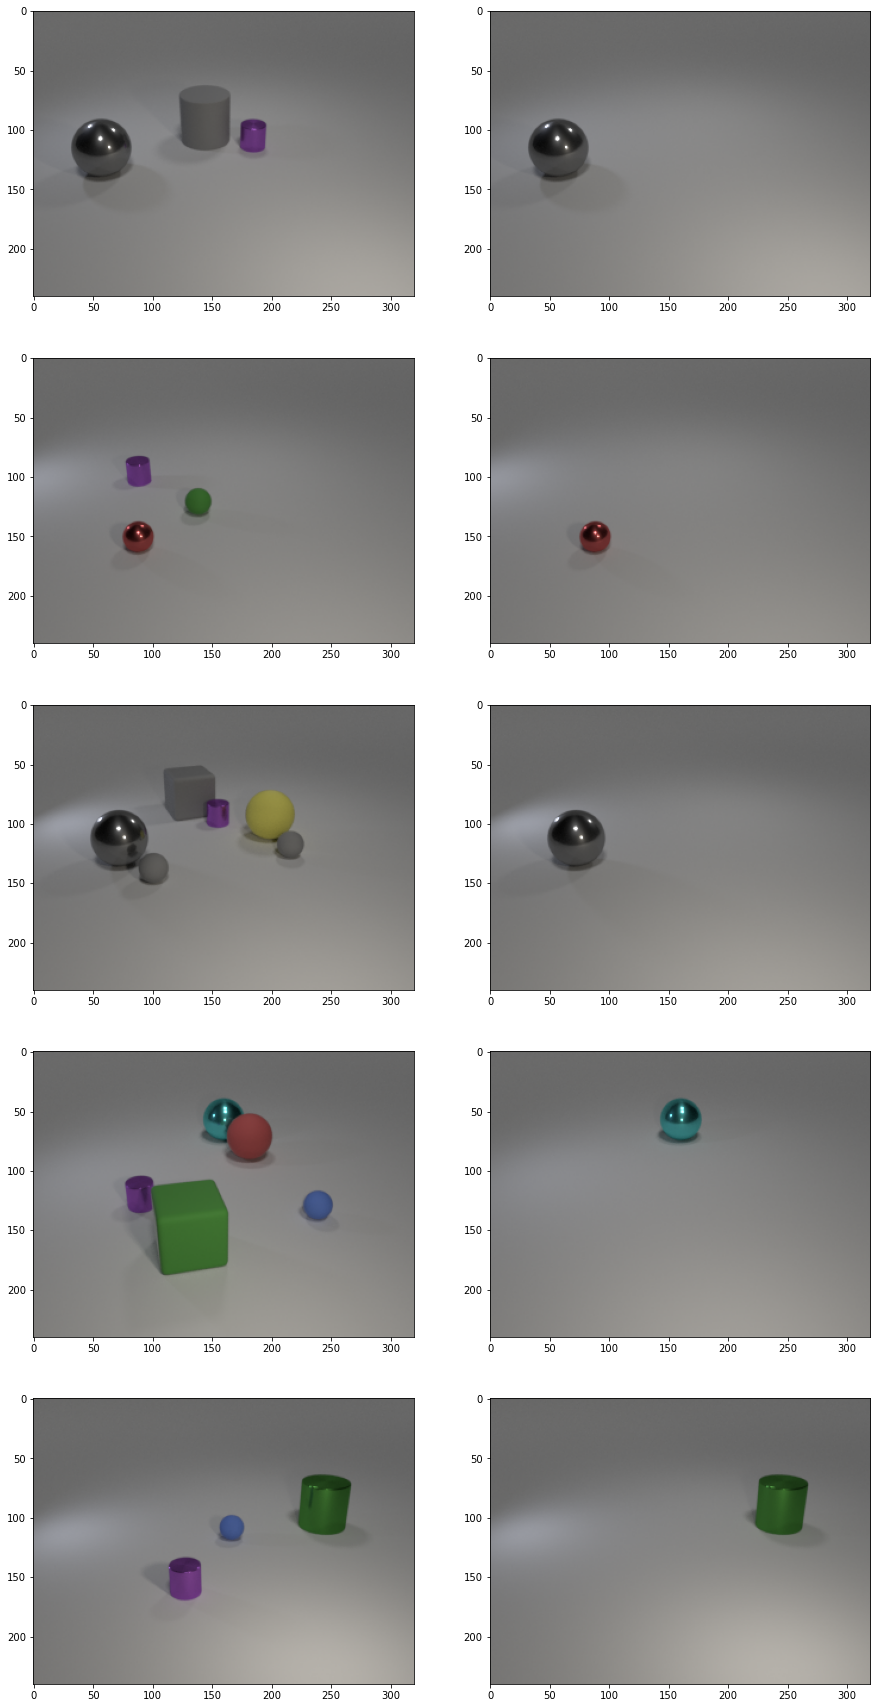

In [59]:
# Visualize the dataset

import matplotlib.pyplot as plt

el = dataset[5]

# Find a compound task
# for el in dataset:
#     if "+" in el["task_str"]:
#         break
# else:
#     assert False
    
print(el["task_str"])
print(el["questions"][0]["question"])

plt.figure(figsize=(15,50)) # specifying the overall grid size

for i in range(min(len(el["inputs"]), 5)):
    plt.subplot(len(el["inputs"]),2, 2 * i + 1)
    plt.imshow(el["inputs"][i]["image"].permute(1, 2, 0))
    plt.subplot(len(el["inputs"]),2, 2 * i + 2)
    plt.imshow(el["outputs"][i].permute(1, 2, 0))

plt.show()

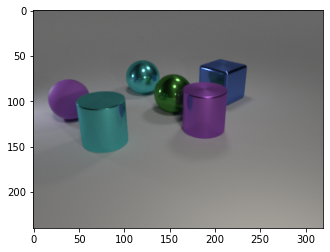

In [12]:
from PIL import Image
plt.imshow(Image.open("/dfs/user/tailin/.results/CLEVR_relation/test1/0/images/CLEVR_new_000000.png"))

In [43]:
dataset.pickle("relations-dataset-322.pgz")

In [50]:
dataset = ClevrRelationDataset(pickle_file="/dfs/user/tailin/.results/CLEVR_relation/relations-dataset-322.pgz")

Loaded 322 tasks.
